In [ ]:
#this code operates on google colab
from google.colab import files
uploaded = files.upload()


Saving f04.wav to f04.wav


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio, display
import math


Loaded: f04.wav fs= 16000 shape= (27675,) dtype= int16
Duration (s): 1.7296875


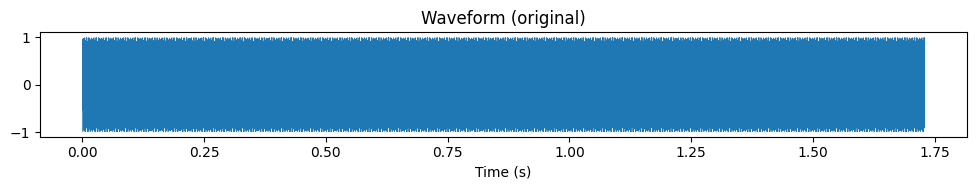

In [4]:
fn = list(uploaded.keys())[0]
fs, x = wavfile.read(fn)
print("Loaded:", fn, "fs=", fs, "shape=", x.shape, "dtype=", x.dtype)

if x.dtype == np.int16:
    x = x.astype(np.float32)/32768.0
elif x.dtype == np.int32:
    x = x.astype(np.float32)/2147483648.0
elif x.dtype == np.uint8:
    x = (x.astype(np.float32)-128)/128.0
else:
    x = x.astype(np.float32)

if x.ndim > 1:
    x = x.mean(axis=1)

x = x / (np.max(np.abs(x)) + 1e-12)

print("Duration (s):", len(x)/fs)

t = np.arange(len(x))/fs
plt.figure(figsize=(10,2))
plt.plot(t, x, linewidth=0.5)
plt.title("Waveform (original)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


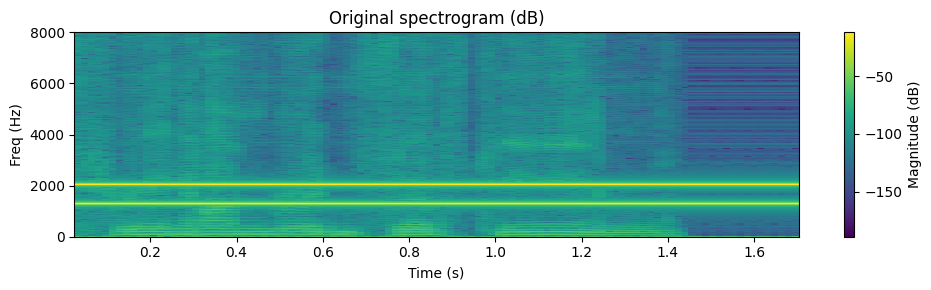

In [5]:
def plot_spectrogram(sig, fs, title="Spectrogram", nperseg=1024, noverlap=768):
    f, t, Sxx = signal.spectrogram(sig, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='spectrum', mode='magnitude')
    plt.figure(figsize=(10,3))
    plt.pcolormesh(t, f, 20*np.log10(Sxx+1e-12), shading='auto')
    plt.ylim(0, min(8000, fs//2))
    plt.colorbar(label='Magnitude (dB)')
    plt.title(title)
    plt.ylabel('Freq (Hz)')
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

plot_spectrogram(x, fs, "Original spectrogram (dB)")


Detected notch candidates (Hz): [np.float64(2050.048828125), np.float64(1300.048828125), np.float64(2046.875), np.float64(1296.875), np.float64(98.14453125), np.float64(1303.7109375)]


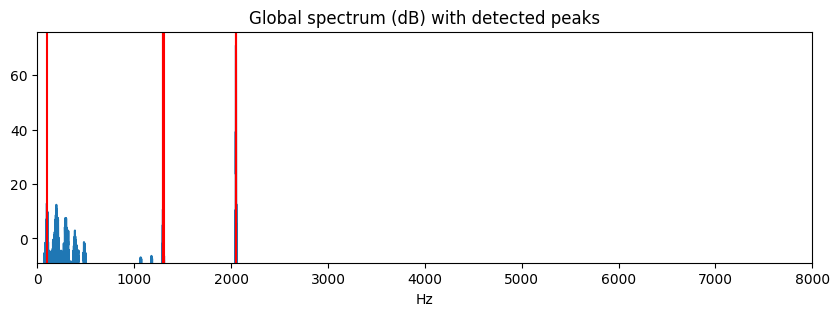

In [6]:
def detect_tonal_peaks(sig, fs, nfft=65536, prominence_db=20, max_notches=6, min_freq=40, max_freq=None):
    if max_freq is None:
        max_freq = fs//2 - 50
    win = np.hanning(len(sig))
    S = np.fft.rfft(sig * win, n=nfft)
    freqs = np.fft.rfftfreq(nfft, 1/fs)
    mag_db = 20*np.log10(np.abs(S)+1e-12)
    from scipy.signal import find_peaks
    peaks, props = find_peaks(mag_db, height=None, prominence=prominence_db)
    peaks = [p for p in peaks if freqs[p] >= min_freq and freqs[p] <= max_freq]
    peaks = sorted(peaks, key=lambda p: mag_db[p], reverse=True)
    chosen = peaks[:max_notches]
    freqs_chosen = [freqs[p] for p in chosen]
    mags = [mag_db[p] for p in chosen]
    return freqs_chosen, mags, freqs, mag_db


freqs_chosen, mags, freqs, mag_db = detect_tonal_peaks(x, fs, nfft=65536, prominence_db=18, max_notches=6)
print("Detected notch candidates (Hz):", freqs_chosen)
plt.figure(figsize=(10,3))
plt.plot(freqs, mag_db)
for f0 in freqs_chosen:
    plt.axvline(f0, color='r')
plt.xlim(0, min(8000, fs/2))
plt.ylim(np.max(mag_db)-80, np.max(mag_db)+5)
plt.title("Global spectrum (dB) with detected peaks")
plt.xlabel("Hz")
plt.show()


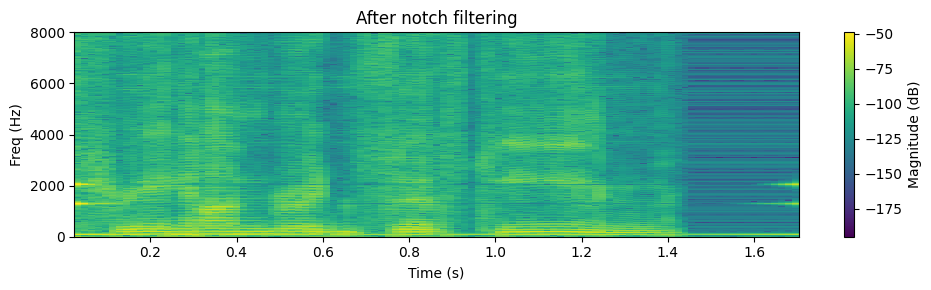

In [7]:
def apply_notch_filters(sig, fs, notch_freqs, Q=60):
    y = sig.copy()
    for f0 in notch_freqs:
        b, a = signal.iirnotch(f0/(fs/2), Q)
        y = signal.filtfilt(b, a, y)
    return y

if len(freqs_chosen) > 0:
    x_notched = apply_notch_filters(x, fs, freqs_chosen, Q=60)
else:
    x_notched = x.copy()

plot_spectrogram(x_notched, fs, "After notch filtering")
display(Audio(x_notched, rate=fs))
